In [1]:
import sys

sys.path.append(".")

from src.models.unet import UNetWithCFG
from src.components.components import *

from src.modules.diffusion_model_cfg import DiffusionModelCFG

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import pytorch_lightning as pl


/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

Device: cuda



# 3

(3 pt.) Implement and train classifier-free guidance using class label. Condition U-net thought input channel and using cross-attention

In [4]:
unet_cfg = UNetWithCFG(
    in_channels=1,
    out_channels=1,
    base_channels=32,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)

diffusion_module_cfg = DiffusionModelCFG(unet_cfg, T=1000, beta_start=1e-4, beta_end=2e-2, lr=1e-4).to(device)

In [7]:
unet_cfg

UNetWithCFG(
  (class_embedding): Embedding(10, 32)
  (time_embedding): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (initial_conv): Conv2d(33, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): DownBlock(
      (res_blocks): ModuleList(
        (0-1): 2 x ResBlock(
          (time_mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=32, bias=True)
          )
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (residual_conv): Identity()
        )
      )
      (downsample): Downsample(
        (conv): Conv2d(32, 32, 

In [5]:
retrain = False

if retrain:
    trainer = pl.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(diffusion_module_cfg, train_loader)
    torch.save(diffusion_module_cfg.unet, 'models/weights/dm_unet_cfg.pth')
else:
    diffusion_module_cfg.unet = torch.load('models/weights/dm_unet_cfg.pth', weights_only=False).to(device)

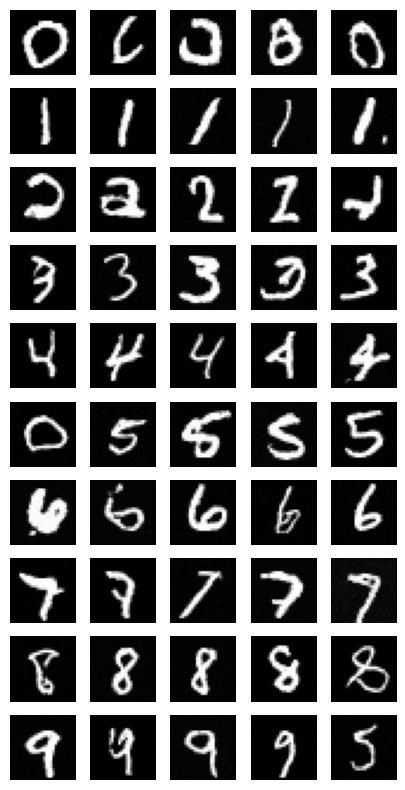

In [6]:
fig, axes = plt.subplots(10, 5, figsize=(5, 10))
for digit in range(10):
    samples = diffusion_module_cfg.sample_ddim(batch_size=5, size=(1, 28, 28), ddim_steps=100, cond=digit)
    for i, ax in enumerate(axes[digit]):
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
plt.show()